# Doudou le hamster surveillé

Doudou est un hamster sans mémoire, bref, une chaîne de Markov, cf. [l'exemple Wikipédia éponyme](https://fr.wikipedia.org/wiki/Cha%C3%AEne_de_Markov#Exemple_:_Doudou_le_hamster).

![](doudou.png)

Dessin par gravgun, [Wikipédia](https://commons.wikimedia.org/w/index.php?curid=41513499), CC BY-SA 4.0.

In [1]:
from enum import Enum

class State(Enum):
    DODO = 0
    MIAM = 1
    RUN = 2

states = [State.DODO, State.MIAM, State.RUN]

In [2]:
from scipy.stats import multivariate_normal
import numpy as np

distributions = {
    State.DODO: multivariate_normal([3, 4], np.diag([0.5, 0.5])),
    State.MIAM: multivariate_normal([2, 2], np.diag([1, 1.5])),
    State.RUN: multivariate_normal([1, 4], np.diag([1, 2]))    
}

sampler = {state: distributions[state].rvs for state in states}  # Sample from distribution
likelihood = {state: distributions[state].pdf for state in states}  # Compute likelihood of sample via probability density function

Faire connaissance avec les objets du sujet (cf. aussi l'annexe plus bas pour `scipy.stats.multivariate_normal`) :

In [3]:
coordinates = sampler[State.MIAM]()  # Sample coords from MIAM state
coordinates

array([2.39471816, 2.28364474])

In [4]:
for state in states:
    print(state, likelihood[state](coordinates))  # How likely will it come from this distribution?

State.DODO 0.011597434611329047
State.MIAM 0.11702953411795441
State.RUN 0.020373120366568142


In [5]:
samples = {state: sampler[state](size=100) for state in states}

samples[State.RUN].shape

(100, 2)

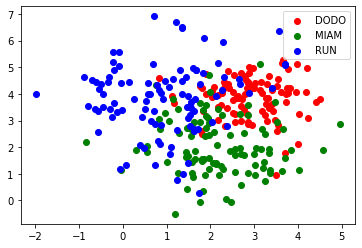

In [6]:
import matplotlib.pyplot as plt

for state, subset in samples.items():
    plt.scatter(subset[:, 0], subset[:, 1], c='rgb'[state.value], label=state.name)
plt.legend()

La matrice de transition de Doudou telle qu'indiquée dans Wikipédia, n'hésitez pas à modifier si vous souhaitez qu'il dorme moins.

In [7]:
transition = np.zeros((3, 3))
transition[State.DODO.value, State.DODO.value] = 9/10
transition[State.DODO.value, State.MIAM.value] = 1/10 / 2
transition[State.DODO.value, State.RUN.value] = 1/10 / 2
transition[State.MIAM.value, State.RUN.value] = 3/10
transition[State.MIAM.value, State.DODO.value] = 7/10
transition[State.RUN.value, State.DODO.value] = 8/10
transition[State.RUN.value, State.RUN.value] = 2/10
transition

array([[0.9 , 0.05, 0.05],
       [0.7 , 0.  , 0.3 ],
       [0.8 , 0.  , 0.2 ]])

In [8]:
# Convergence, just for fun
transition @ transition @ transition @ transition @ transition @ transition @ transition @ transition @ transition @ transition @ transition @ transition

array([[0.8839779, 0.0441989, 0.0718232],
       [0.8839779, 0.0441989, 0.0718232],
       [0.8839779, 0.0441989, 0.0718232]])

Donc Doudou dort 88,4 % du temps, comme indiqué sur l'article Wikipédia.

In [9]:
def random_step(z):
    return np.random.choice(states, p=transition[z.value])

In [10]:
def random_walk(n_steps=10):
    walk = [State.DODO]
    for _ in range(n_steps):
        walk.append(random_step(walk[-1]))
    return walk

In [11]:
random_walk(15)

[<State.DODO: 0>,
 <State.DODO: 0>,
 <State.RUN: 2>,
 <State.DODO: 0>,
 <State.MIAM: 1>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.RUN: 2>,
 <State.DODO: 0>,
 <State.RUN: 2>,
 <State.DODO: 0>,
 <State.DODO: 0>]

In [12]:
def encode(states):
    return np.array([sampler[state]() for state in states])

In [13]:
hidden = random_walk(500)
observations = encode(hidden)

Représentons-les.

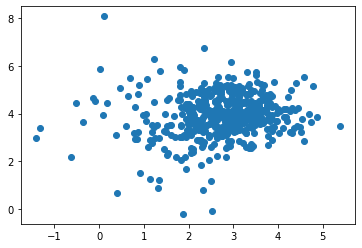

In [14]:
plt.scatter(observations[:, 0], observations[:, 1])

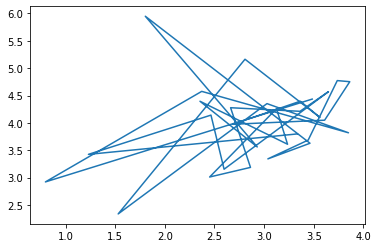

In [15]:
plt.plot(observations[:30, 0], observations[:30, 1])

Le but est d'implémenter l'[algorithme de Viterbi](https://en.wikipedia.org/wiki/Viterbi_algorithm) pour identifier la séquence d'états de Doudou la plus probable.

In [16]:
def decode(observations):
    K = 3
    N_STEPS = len(observations)
    
    T = [[(float('-inf'), None)] * N_STEPS for _ in range(K)]
    # Initially, p(dodo) = 1, p(other) = 0
    T[State.DODO.value][0] = (np.log(likelihood[State.DODO](observations[0])), None)
    
    # T[i][j] contains a pair (best_proba, argmax_k), thanks Hugo Manet
    # We can also keep track of predecessors in a dict, possibly more readable, but needs loops or argmax
    for j in range(1, N_STEPS):
        for i in range(K):
            T[i][j] = (max((np.log(likelihood[states[i]](observations[j])) +
                            np.log(transition[k][i]) + T[k][j - 1][0], k) for k in range(K)))
    T = np.array(T)
    state_path = [None] * N_STEPS
    state_path[N_STEPS - 1] = states[T[:, -1, 0].argmax()]
    for t in range(N_STEPS - 2, -1, -1):
        state_path[t] = states[T[state_path[t + 1].value][t + 1][1]]    
    return state_path, T

In [17]:
state_path, T = decode(observations)

/tmp/ipykernel_12935/3960492278.py:14: RuntimeWarning: divide by zero encountered in log
  np.log(transition[k][i]) + T[k][j - 1][0], k) for k in range(K)))


In [18]:
state_path[:20]

[<State.DODO: 0>,
 <State.RUN: 2>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.MIAM: 1>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>,
 <State.DODO: 0>]

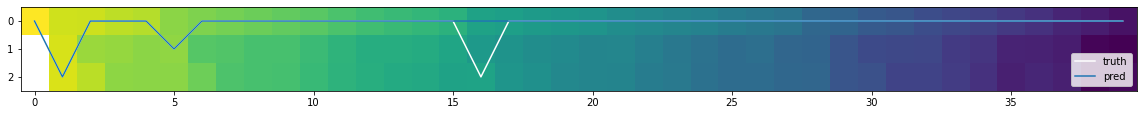

In [19]:
PREVIEW_LENGTH = 40
fig, ax = plt.subplots(figsize=(20, 10))
preview = T[:, :PREVIEW_LENGTH, 0].astype(float)
plt.plot(range(PREVIEW_LENGTH), [state.value for state in hidden[:PREVIEW_LENGTH]], label='truth', c='white')
plt.plot(range(PREVIEW_LENGTH), [state.value for state in state_path[:PREVIEW_LENGTH]], label='pred')
plt.imshow(preview)
plt.legend()

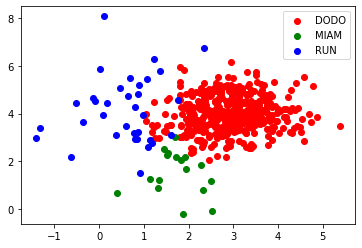

In [20]:
pos = {state: [] for state in states}
for i, state in enumerate(state_path):
    pos[state].append(i)
for state in states:
    plt.scatter(observations[pos[state], 0], observations[pos[state], 1], c='rgb'[state.value], label=state.name)
plt.legend()

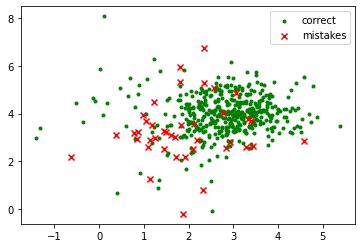

In [21]:
correct = np.array(hidden) == np.array(state_path)
mistakes = np.array(hidden) != np.array(state_path)
plt.scatter(observations[correct, 0], observations[correct, 1], c='g', marker='.', label='correct')
plt.scatter(observations[mistakes, 0], observations[mistakes, 1], c='r', marker='x', label='mistakes')
plt.legend()

In [22]:
correct.mean()

0.9201596806387226

In [23]:
hidden.count(State.DODO) / len(observations)

0.8642714570858283

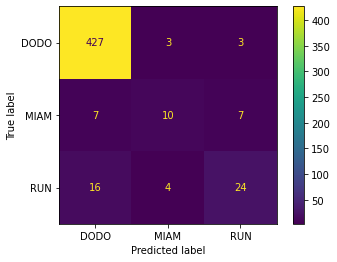

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions([state.value for state in hidden], [state.value for state in state_path],
                                        display_labels=[state.name for state in states])

## Annexe : comprendre la densité de probabilité

Gaussienne univariée

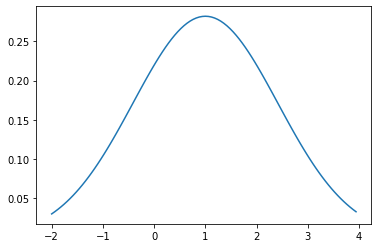

In [25]:
x = np.linspace(-2, 4, 100, endpoint=False)
y = multivariate_normal.pdf(x, mean=1, cov=2); y
fig1 = plt.figure()
ax = fig1.add_subplot(111)
ax.plot(x, y)

In [26]:
multivariate_normal(1, 2).pdf(2.5)  # Vraisemblance d'observer cette valeur

0.16073276729880184

In [27]:
multivariate_normal(1, 2).pdf(1)

0.28209479177387814

In [28]:
multivariate_normal(1, 2).pdf(10)

4.5282647397717146e-10

En gaussienne multivariée

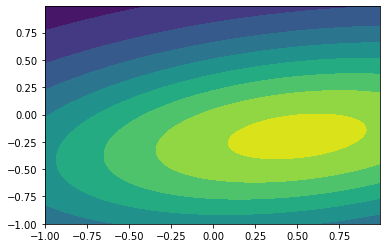

In [29]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))

## Références

> Bishop, Christopher M. (2006). [Pattern Recognition and Machine Learning.](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)

mais il y a des typos précisément dans la partie sur l'algorithme de Viterbi, donc nous recommandons plutôt

> Murphy, Kevin P (2012). [Machine Learning: A Probabilistic Perspective.](http://noiselab.ucsd.edu/ECE228/Murphy_Machine_Learning.pdf) MIT Press.

Merci Guillaume Obozinski.